# 긍정, 부정 감성 분석

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

4907008/4893335 [==============================] - 0s 0us/step


# 데이터 로드 및 확인

In [3]:
# 데이터를 메모리에 불러옵니다. 인코딩 형식으로 utf-8을 지정해야 합니다.
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

# 텍스트가 총 몇 자인지 확인한다.
print('Length of text: {} characters'.format(len(train_text)))
print('Length of text: {} characters'.format(len(test_text)))
print()

# 처음 300자를 확인한다.
print(train_text[:300])

Length of text: 6937271 characters
Length of text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


# 학습을 위한 정답 데이터(Y) 만들기

In [4]:
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [5]:
import re

In [6]:
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", " ", string)
    string = re.sub(r"\'", " ", string)
    
    return string.lower()

In [7]:
train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]

for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


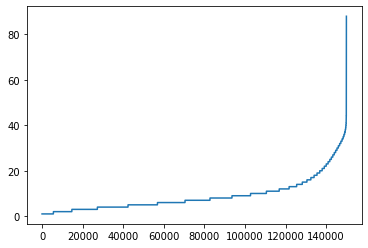

142552


In [8]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [9]:
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
    
sentences = sentences_new

for i in range(5):
    print(sentences[i], ", Y = ", train_Y[i])

['아', '더빙', '진짜', '짜증나네요', '목소리'] , Y =  [0]
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나'] , Y =  [1]
['너무재밓었'] , Y =  [0]
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'] , Y =  [0]
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다'] , Y =  [1]


# Tokenizer와 pad_sequences를 이용한 문장 전처리

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
train_X = pad_sequences(train_X, padding='post')

print(train_X[:5])

[[   25   887     8  5802  1112     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  589  5803  6695     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  107  5339     4     2  2208   873   578     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


# Tokenizer의 동작 확인

In [11]:
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])

temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가'])
print(temp)

temp = pad_sequences(temp, padding='post')
print(temp)

짐캐리가
필요있나
[[], [], [], [107]]
[[  0]
 [  0]
 [  0]
 [107]]


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy'])
model.summary()

2022-02-21 18:11:45.668050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-21 18:11:45.668304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
938/938 [==============================] - 41s 43ms/step - loss: 0.6873 - accuracy: 0.5270 - val_loss: 0.6453 - val_accuracy: 0.6229
Epoch 2/5
938/938 [==============================] - 41s 44ms/step - loss: 0.5998 - accuracy: 0.6662 - val_loss: 0.5708 - val_accuracy: 0.6946
Epoch 3/5
938/938 [==============================] - 41s 44ms/step - loss: 0.5451 - accuracy: 0.7102 - val_loss: 0.5379 - val_accuracy: 0.7219
Epoch 4/5
938/938 [==============================] - 41s 44ms/step - loss: 0.5047 - accuracy: 0.7437 - val_loss: 0.5053 - val_accuracy: 0.7461
Epoch 5/5
938/938 [==============================] - 41s 44ms/step - loss: 0.4727 - accuracy: 0.7661 - val_loss: 0.4870 - val_accuracy: 0.7590


# 감성 분석 모델의 학습 결과 확인

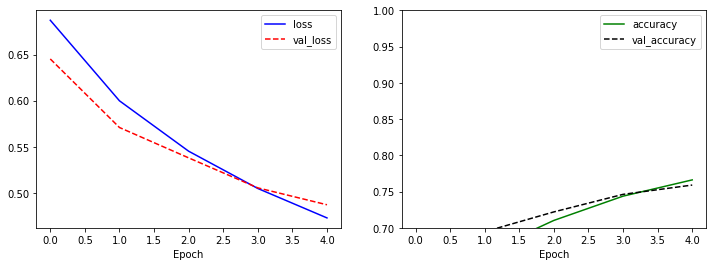

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

# 테스트 데이터 평가

In [16]:
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]

sentences_new = []

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
    
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

model.evaluate(test_X, test_Y, verbose=0)

[0.49054715037345886, 0.7533800601959229]

# 임의의 문장에 대한 감성 분석 결과 확인

In [19]:
# test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
# 0:부정 , 1:긍정
test_sentence = '생각보다 재미있었다. 영화보기를 강력 추천합니다.'
test_sentence = test_sentence.split(' ')

test_sentences = []
now_sentence = []

for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)

prediction = model.predict(test_X_1)

for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

['생각보다']
[0.54757726 0.45242277]
['생각보다', '재미있었다.']
[0.54757726 0.45242277]
['생각보다', '재미있었다.', '영화보기를']
[0.54757726 0.45242277]
['생각보다', '재미있었다.', '영화보기를', '강력']
[0.3326245 0.6673755]
['생각보다', '재미있었다.', '영화보기를', '강력', '추천합니다.']
[0.3326245 0.6673755]
